In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. 'monthly-us-auto-registration-tho.csv'

In [51]:
df_auto_reg = pd.read_csv('monthly-us-auto-registration-tho.csv', delimiter=';')

In [52]:
df_auto_reg.head(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214


In [53]:
df_auto_reg.tail(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
262,1968-11,757
263,1968-12,977


In [54]:
df_auto_reg.columns = ['Month', 'Registrations']

In [55]:
df_auto_reg.head()

,Month,Registrations
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


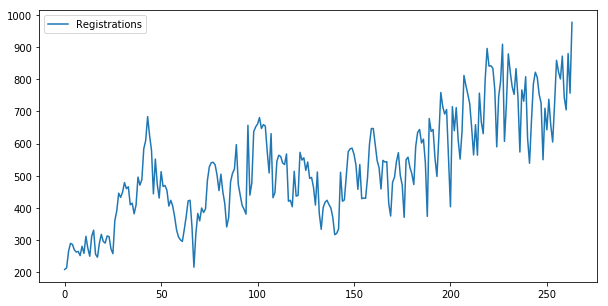

In [56]:
fig = df_auto_reg.plot(figsize=(10,5))

Имеется явный тренд, сезонность тяжело понять

In [57]:
from statsmodels.tsa.stattools import adfuller

In [58]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [59]:
test_stationarity(df_auto_reg['Registrations'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Ряд нестационарен, требуются преобразования.

Для начала нормализуем дисперсию.

In [60]:
from scipy.stats import boxcox

In [61]:
df_auto_reg['Registrations_box'] = boxcox(df_auto_reg['Registrations'])[0]

In [62]:
test_stationarity(df_auto_reg['Registrations_box'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.548473
p-value                          0.509411
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Попробуем определить сезонность

In [90]:
for i in range(1, 13):
    print(i, df_auto_reg['Registrations_box'].autocorr(i))

1 0.871502565232885
2 0.8014175143156537
3 0.762345495229259
4 0.7427713345018171
5 0.7318066650311804
6 0.7122248514288037
7 0.6971601524246762
8 0.6773805951257351
9 0.6517673803729533
10 0.6444315482698804
11 0.6728426074503588
12 0.7533594096432292


In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [67]:
result = seasonal_decompose(df_auto_reg['Registrations_box'], freq=12)

<Figure size 1152x576 with 0 Axes>

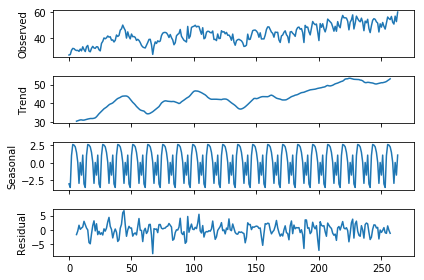

In [68]:
plt.figure(figsize=(16,8))
fig = result.plot()

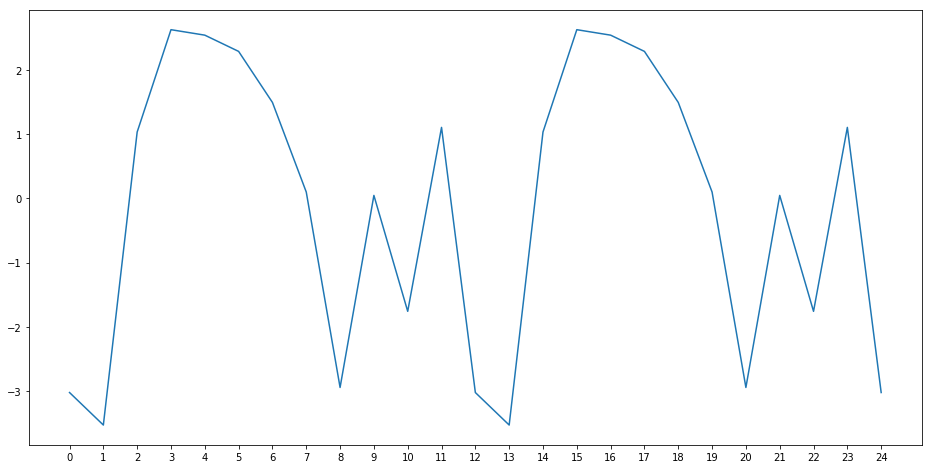

In [69]:
plt.figure(figsize=(16,8))
fig = result.seasonal[:25].plot()
tics = plt.xticks(range(25))

Похоже есть сезонность с периодом в 12 месяцев.

Возьмем сезонную разницу

In [70]:
df_auto_reg['Registrations_box_season'] = df_auto_reg['Registrations_box'].diff(12)

In [71]:
test_stationarity(df_auto_reg['Registrations_box_season'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -4.156235
p-value                          0.000781
#Lags Used                      12.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


Т.к. p-value < 0.05, то мы отвергаем гипотезу $H_0$ и принимаем альтернативную, что ряд временной стационарен. Однако прежде, чем окончательно отвергнуть гипотезу о нестационарности ряда необходимо посмотреть на коррелограммы.

In [72]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [73]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


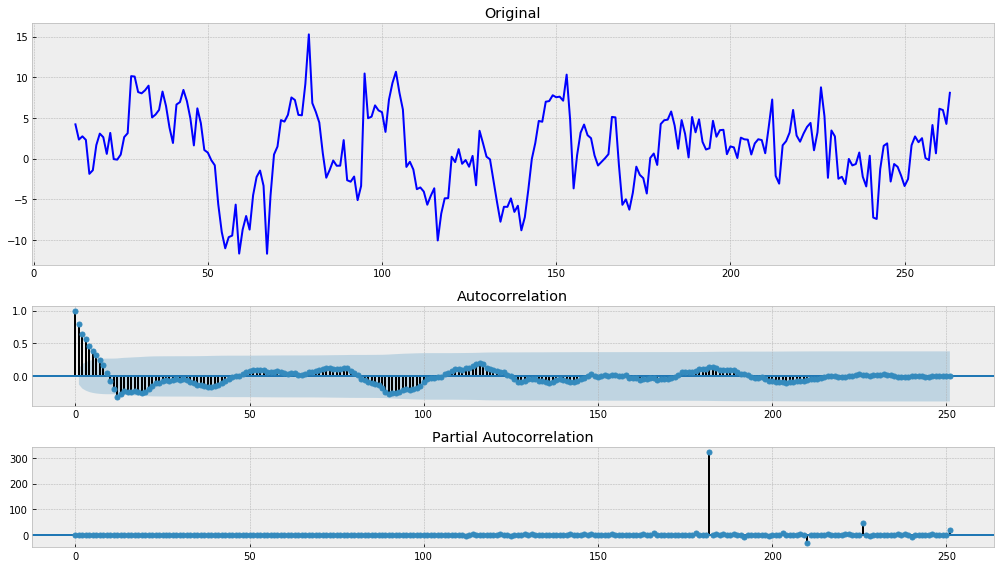

In [74]:
tsplot(df_auto_reg['Registrations_box_season'].dropna())

Ряд еще не стационарен. Возьмем первые разности.

In [75]:
df_auto_reg['Registrations_box_season_diff_1'] = df_auto_reg['Registrations_box_season'].diff()

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


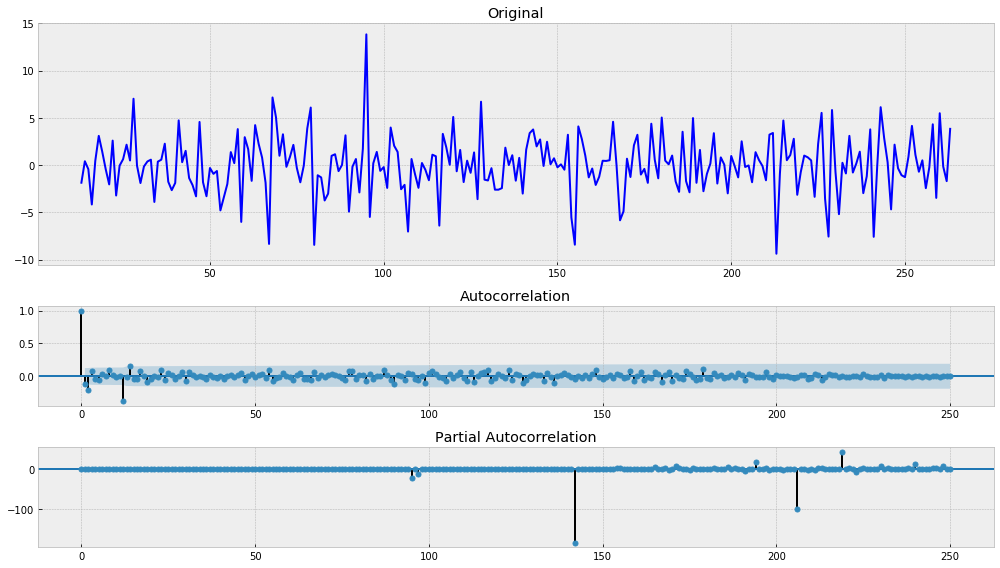

In [76]:
tsplot(df_auto_reg['Registrations_box_season_diff_1'].dropna())

In [77]:
test_stationarity(df_auto_reg['Registrations_box_season_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.604213e+00
p-value                        6.618944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


Теперь можно отвергунть гипотезу о нестационарности ряда и принять гипотезу о стационарности.

### 2. 'weekly-closings-of-the-dowjones-.csv'

In [78]:
df_dow_jones = pd.read_csv('weekly-closings-of-the-dowjones-.csv')

In [79]:
df_dow_jones.head(2)

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
0,1971-W27,890.19
1,1971-W28,901.80


In [80]:
df_dow_jones.tail(2)

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
160,1974-W31,784.57
161,1974-W32,752.58


In [81]:
df_dow_jones.columns = ['Week', 'Closing']

In [82]:
df_dow_jones.head(1)

,Week,Closing
0,1971-W27,890.19


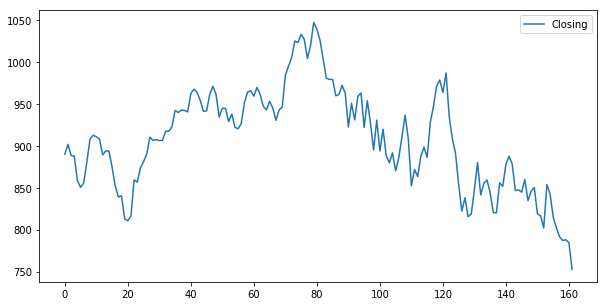

In [83]:
fig = df_dow_jones.plot(figsize=(10,5))

In [84]:
test_stationarity(df_dow_jones['Closing'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


Ряд нестационарен, требуются преобразования.

Для начала нормализуем дисперсию.

In [85]:
df_dow_jones['Closing_box'] = boxcox(df_dow_jones['Closing'])[0]

In [86]:
test_stationarity(df_dow_jones['Closing_box'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.327773
p-value                          0.616372
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


Попробуем определить сезонность

In [91]:
for i in range(1, 53):
    print(i, df_dow_jones['Closing_box'].autocorr(i))

1 0.9458570338080939
2 0.895895317271834
3 0.8428225452858994
4 0.7825695829558579
5 0.7369597927045546
6 0.6807119790002728
7 0.6445025709752716
8 0.614805483814812
9 0.5878784910128302
10 0.5719882434069529
11 0.5498313859155526
12 0.538573074222197
13 0.5283548540326318
14 0.5045461018379386
15 0.47650784608384644
16 0.43359032540428394
17 0.41013358707044983
18 0.3871227757437938
19 0.36791170861199174
20 0.3675896007868483
21 0.35439709709530837
22 0.35686817372486757
23 0.34286691531067637
24 0.31769752077417074
25 0.2868292873286624
26 0.2514428610061842
27 0.22264786076645554
28 0.20527716339696805
29 0.18021202799229832
30 0.15653747075882152
31 0.15017539055447546
32 0.15094653153368606
33 0.132679679557251
34 0.09840997088720443
35 0.06357362500177856
36 0.01713600849096387
37 -0.011061739342100531
38 -0.03244344091973781
39 -0.05829722781324038
40 -0.07550695420262232
41 -0.07145357648364727
42 -0.06941258990563
43 -0.06460111273226478
44 -0.06290415388100311
45 -0.05777572

Похоже сезонность отсутствует

In [96]:
df_dow_jones.head(1)

,Week,Closing,Closing_box
0,1971-W27,890.19,1935.977038


Возьмем первые разности.

In [103]:
df_dow_jones['Closing_box_diff_1'] = df_dow_jones['Closing_box'].diff()

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


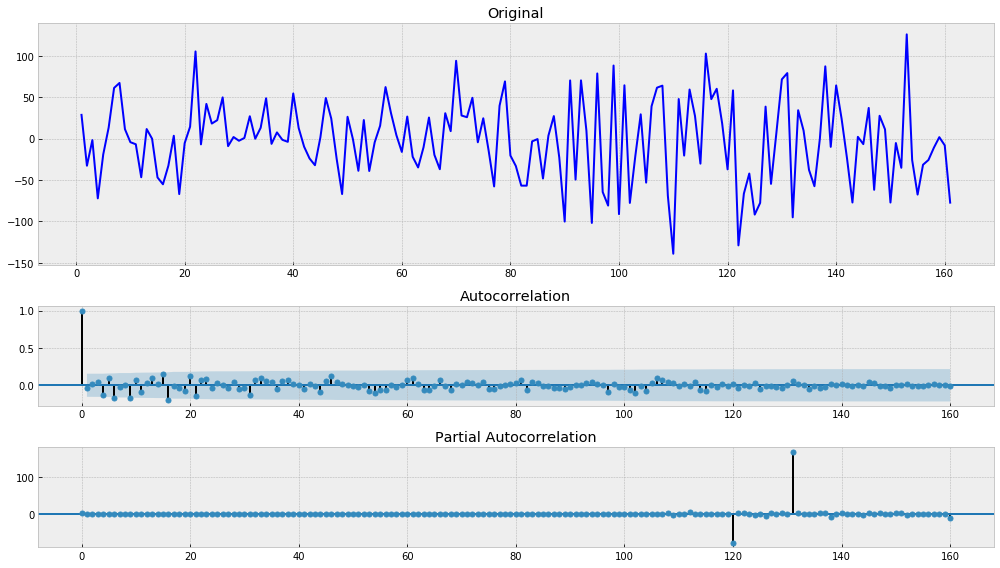

In [104]:
tsplot(df_dow_jones['Closing_box_diff_1'].dropna())

In [105]:
test_stationarity(df_dow_jones['Closing_box_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.302750e+01
p-value                        2.382691e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


Теперь можно отвергунть гипотезу о нестационарности ряда и принять гипотезу о стационарности.